# Load as a torchaudio style dataset

This notebook requires `librosa` and `matplotlib` beyond `pmqd`. Uncomment below to install the requirements.

In [ ]:
# !pip install git+https://github.com/Peltarion/pmqd#egg=pmqd
# !pip install librosa matplotlib
# !pip install torchaudio==0.11.0
# !pip install pytorch-msssim

----------

In [7]:
import itertools
import random
from typing import Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio.transforms as T
from IPython.display import Audio
from IPython.core.display_functions import display
from librosa.display import specshow
from pmqd.torch import PMQD
from torch.utils.data import Dataset, DataLoader, Subset

from pyramids import LaplacianPyramid
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy.stats import spearmanr
import pandas as pd


First load the dataset and extract the sample_rate.

In [8]:
dataset = PMQD(root="/Users/up20938/Coding/datasets/pmqd", download=False)
sample_rate = PMQD.SAMPLE_RATE

To produce the results in our paper [Perceiving Music Quality with GANs](https://arxiv.org/abs/2006.06287), we used a preprocessing pipeline equivalent to the follwing. It creates log mel spectrogram from the first channel with the shape 256 x 256 (frequency x time).

In [9]:
class TransformedPMQD(Dataset):
    """Transform the first channel of audio and return it together with the rating."""
    
    def __init__(self, dataset: PMQD, transforms: nn.Sequential):
        self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, n: int) -> Tuple[torch.Tensor, torch.Tensor]:
        example = self.dataset[n]
        # channel = example["audio"][0]
        channel = example["audio"].mean(axis=0)

        # return self.transforms(channel), example["rating"]
        return self.transforms(channel), example

In [10]:
# reduced_sample_rate = 48000
# reduced_sample_rate = 48000
# window_size = 4096
# hop_size = 387
# num_mels = 512

reduced_sample_rate = 16050
window_size = 2048
hop_size = 64
num_mels = 512

In [11]:
transforms = nn.Sequential(
    T.Resample(orig_freq=sample_rate, new_freq=reduced_sample_rate),
    T.MelSpectrogram(
        n_mels=num_mels,
        n_fft=window_size,
        win_length=window_size,
        hop_length=hop_size,
        power=1,
        center=False,
        sample_rate=reduced_sample_rate,
        f_min=0,
        f_max=reduced_sample_rate / 2,
        window_fn=torch.hann_window,
        mel_scale='htk',
        norm=None
    ),
)

/Users/up20938/Coding/python/audio-pyramid/venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


tensor(0) One More Holy Night original tensor(4., dtype=torch.float64)


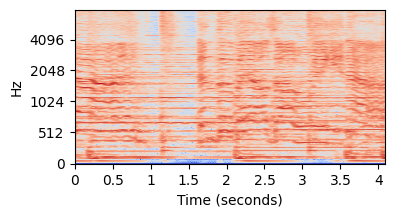

tensor(195) One More Holy Night distortion tensor(2., dtype=torch.float64)


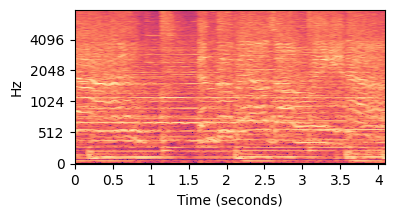

tensor(390) One More Holy Night limiter tensor(4., dtype=torch.float64)


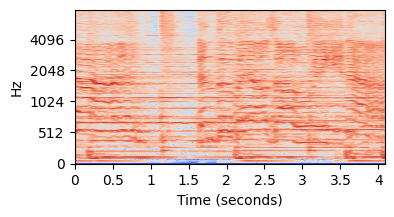

tensor(585) One More Holy Night lowpass tensor(3., dtype=torch.float64)


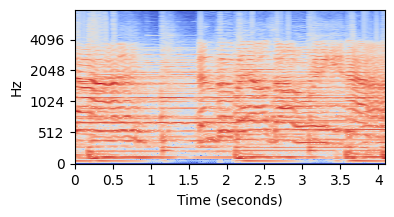

tensor(780) One More Holy Night noise tensor(2., dtype=torch.float64)


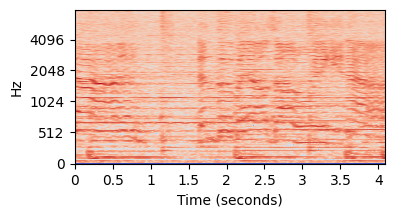

In [12]:
dataloader = DataLoader(TransformedPMQD(dataset, transforms), batch_size=195)
omhn = []
rts = []

for mel_spectrograms, rating in itertools.islice(dataloader, 0, 5):
    print(rating['id'][0], rating['title'][0], rating['degradation_type'][0], rating['rating'][0])
    fig, ax = plt.subplots(1, figsize=(4,2))
    # print(mel_spectrograms[0].shape)
    omhn.append(mel_spectrograms)
    rts.append(rating['rating'])
    specshow(
        torch.log(mel_spectrograms[0] + 1e-3).numpy(),
        sr=reduced_sample_rate,
        hop_length=hop_size,
        x_axis="s",
        y_axis="mel"
    )
    plt.show()

In [13]:
pmd = LaplacianPyramid(6,dims=1)

In [14]:
pyr = pmd.pyramid(omhn[0][0].unsqueeze(0).unsqueeze(0).float())

torch.Size([1, 1, 512, 1024])


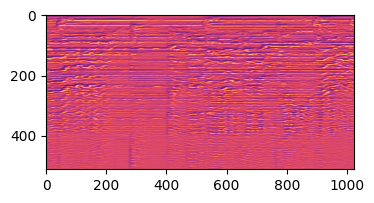

torch.Size([1, 1, 256, 512])


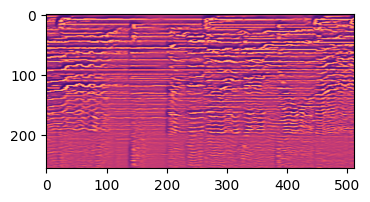

torch.Size([1, 1, 128, 256])


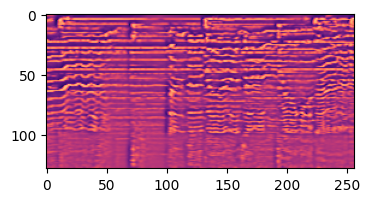

torch.Size([1, 1, 64, 128])


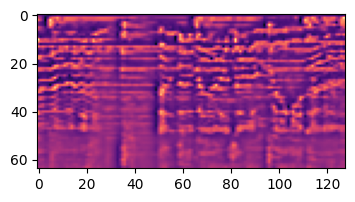

torch.Size([1, 1, 32, 64])


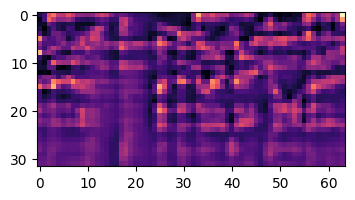

torch.Size([1, 1, 16, 32])


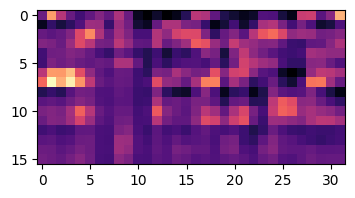

In [15]:
for i in range(len(pyr)):
    pi = pyr[i]
    print(pi.shape)
    # print(pi.min(),pi.max())
    pi = (pi + abs(pi.min()))/(pi + abs(pi.min())).max()
    # print(pi.min(),pi.max())
    fig, ax = plt.subplots(1, figsize=(4,2))
    plt.imshow(pi.squeeze(),cmap='magma')
    plt.show()

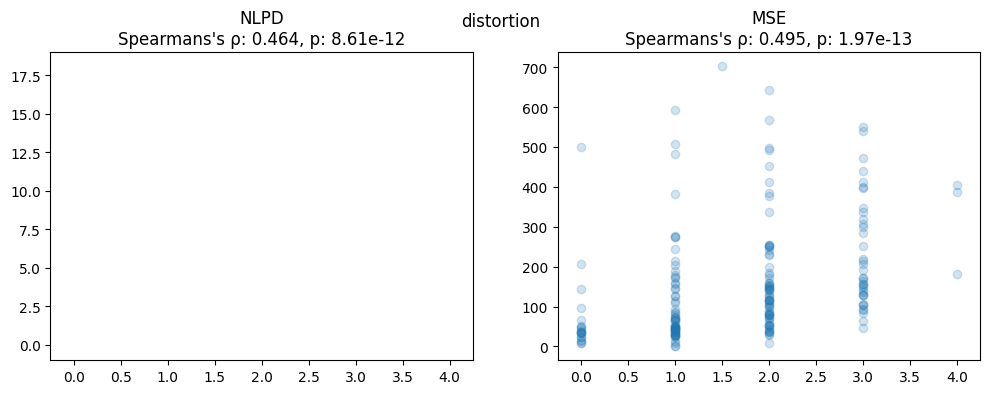

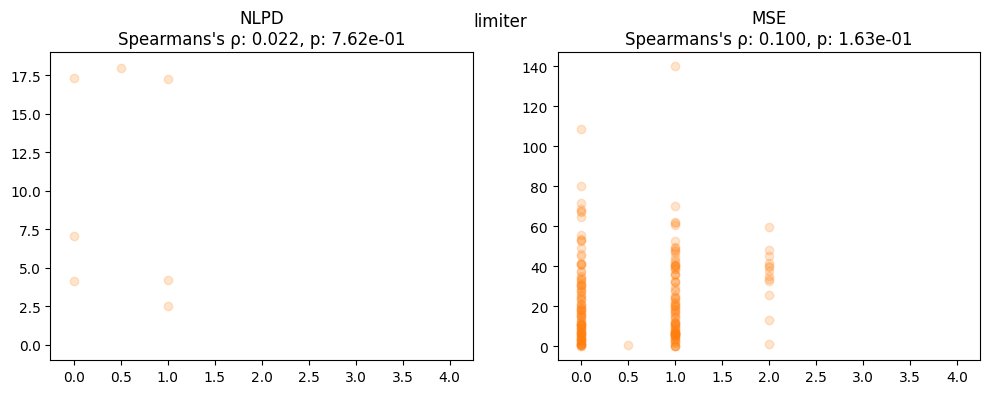

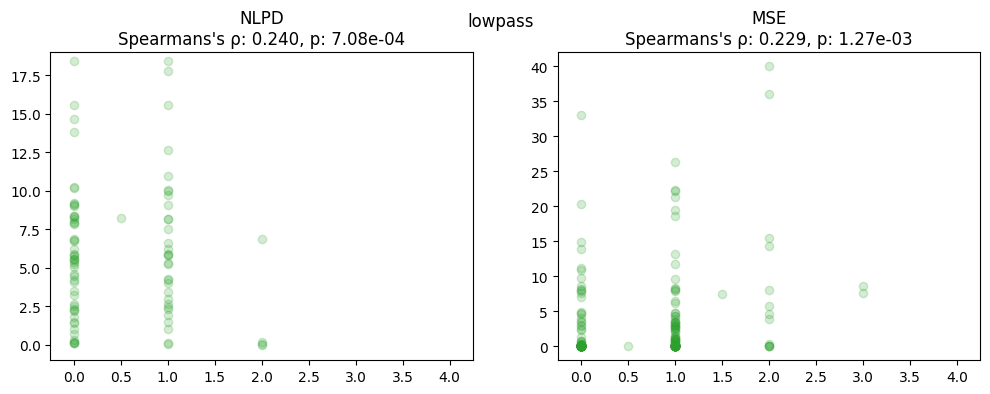

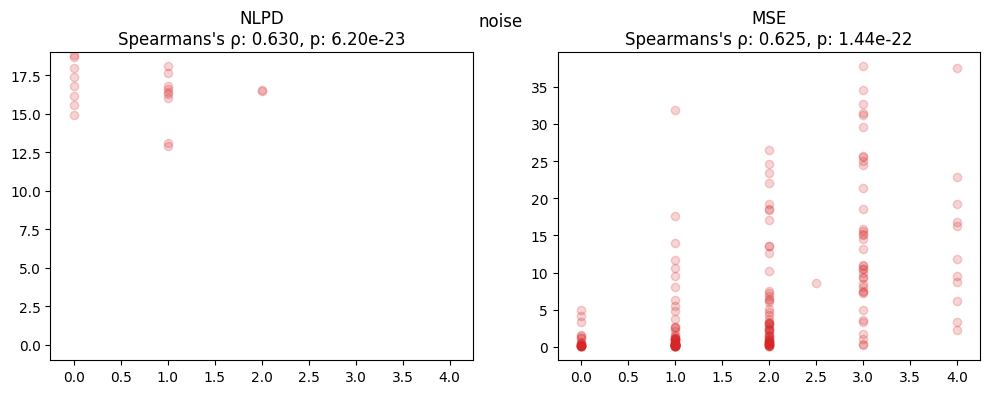

In [16]:
distortions = ['distortion','limiter','lowpass','noise']
combinations = ((0,1),(0,2),(0,3),(0,4))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i1, i2 in combinations:
    pmdiff = []
    radiff = []
    mse = []
    for j in range(195):
        pmdiff.append(pmd.compare(omhn[i1][j].unsqueeze(0).unsqueeze(0).float(), omhn[i2][j].unsqueeze(0).unsqueeze(0).float()))
        mse.append(((omhn[i1][j]-omhn[i2][j])**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

    sppm = spearmanr(radiff,pmdiff)
    spmse = spearmanr(radiff,mse)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 1

    ax[0].set_title(f"NLPD\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")

    ax[0].scatter(radiff,pmdiff, alpha=0.2, c=cycle[i2-1])
    ax[0].set_ylim(0-yoffset,18+yoffset)
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MSE\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,mse, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)

    plt.show()

In [ ]:
# norm 0.6
layers = {'layer1':[.485,.031,.245,.615], 'layer2':[.487,.025,.244,.618], 'layer3':[.481,.028,.245,.621],
          'layer4':[.475,.031,.241,.624], 'layer5':[.463,.025,.241,.628], 'layer6':[.462,.021,.241,.630]}
mse = [.495,.100,.229,.625]

In [ ]:
# norm 1
norm1 = [.461,.022,.239,.629]
# norm 0.3
norm03 = [.464,.022,.240,.630]

In [471]:
# reduced_sample_rate = 16000
# window_size = 2048
# num_mels = 256
# varying hop size:
{2041.32: [.492,.159,.331,.615],
 1021.64: [.500,.152,.321,.622],
 511.128: [.505,.146,.305,.626],
 128.512:[.473,.090,.277,.612]}
# window_size = 2048
# hop_size = 256
# num_mels = 256
# vary sample rate
{124.8000:[.458,.097,.111,.595],
 519.32000: [.498, .105,.270,.635],
 782.48000: [.497,.075,.258,.625], }
# sample reduced_sample_rate = 16000
# num_mels: 256
# hop_size = 256
# vary window_size:
{260.1024: [.508, .109, .282, 630],
 248.4096: [.473,.115,.273,.613],
 232.8192: [.441,.118,.300,.608] }
# sample reduced_sample_rate = 16000
# window_size = 2048
# hop_size = 256
# vary num mels:
{128.256:[.483,.068,.259,.634],
 256.256:[.499, .121, .296, .628],
 512.256:[.511,.135,.275,.635],
 1024.256:[.516,.140,.257,.641]} # but at 1024 there are zeroed (missing) freq bands

# 512 mels
# 64 hop
# 16000 freq
# 2048 window
# 512 x 1021
# vary num layers in pyramid
{4:[.334,.163,.289,.312],
 3: [.512,.162,.300,.626],
 2:[.514,.167,.264,.620],
 1:[.519,.166,.252,.620]}

# 512 mels
# 64 hop
# 16000 freq
# 2048 window
# 512 x 1024
{3: [.513,.160,.296,.626]}
# want a small window size and hop size and a big num mels. max freq doesnt seem to matter much as long as there are enough frequencies to not have empty bands.

# diff nums of layers
# {1:[0.473, 0.102, 0.271, 0.628], 2:[0.455, 0.099, 0.258, 0.624], 3:[0.450, 0.081, 0.267, 0.617], 4:[0.204, -0.017, 0.141, 0.164], 5:[0.127, -0.019, 0.078, 0.180]}

SyntaxError: invalid syntax (2381288223.py, line 15)

In [507]:
combinations = list(itertools.combinations(range(5),2))

In [508]:
pmdiff = []
radiff = []
mse = []
for i1, i2 in combinations:
    for j in range(195):
        pmdiff.append(pmd.compare(omhn[i1][j].unsqueeze(0).unsqueeze(0).float(), omhn[i2][j].unsqueeze(0).unsqueeze(0).float()))
        mse.append(((omhn[i1][j]-omhn[i2][j])**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

In [509]:
sppm = spearmanr(radiff,pmdiff)
spmse = spearmanr(radiff,mse)

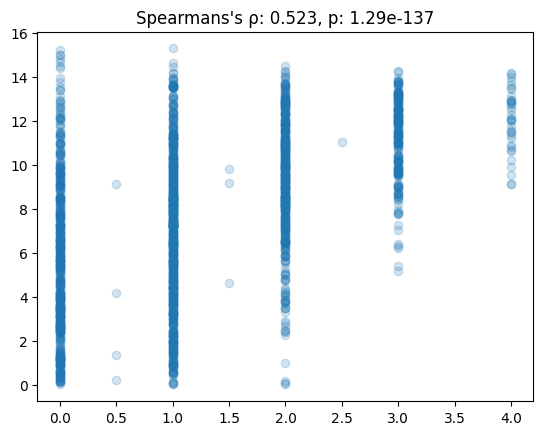

In [510]:
plt.scatter(radiff,pmdiff, alpha=0.2)
plt.title(f"Spearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")
plt.show()

Text(0.5, 1.0, "Spearmans's ρ: 0.273, p: 1.15e-34")

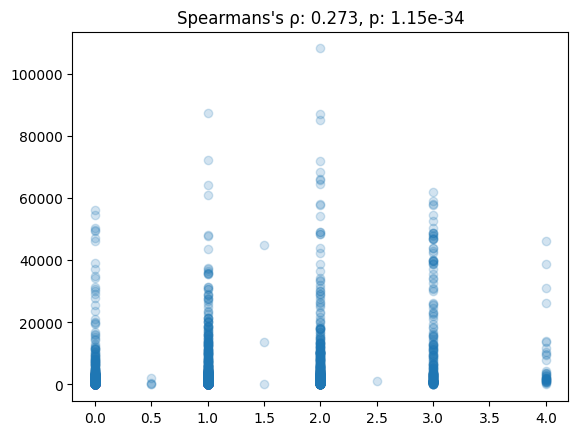

In [49]:
plt.scatter(radiff,mse,alpha=0.2)
plt.title(f"Spearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")

Seperate Classes:

In [51]:
omhn_norm = []
for i in range(len(omhn)):
    # print(omhn[i].min(), omhn[i].max())
    omhn_norm.append((omhn[i]/1302))

In [512]:
combinations = ((0,1),(0,2),(0,3),(0,4))

In [54]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

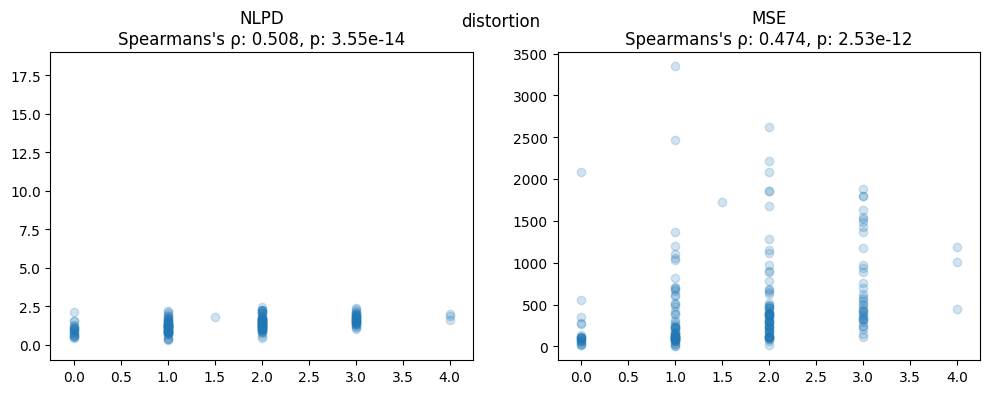

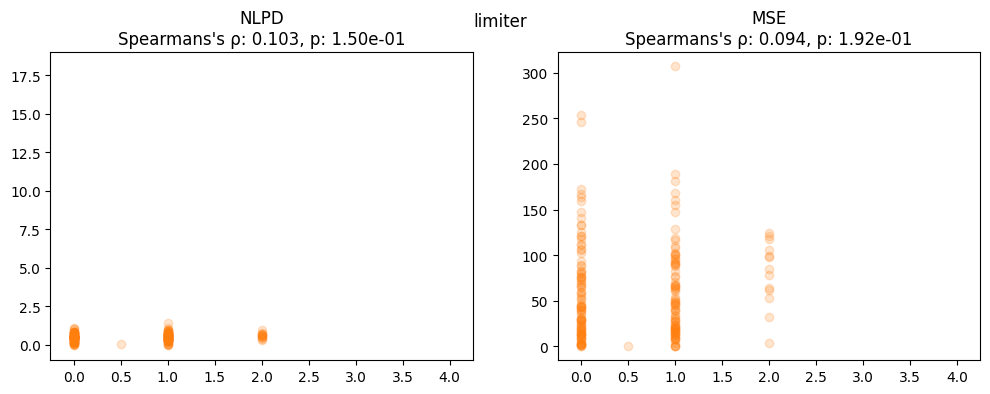

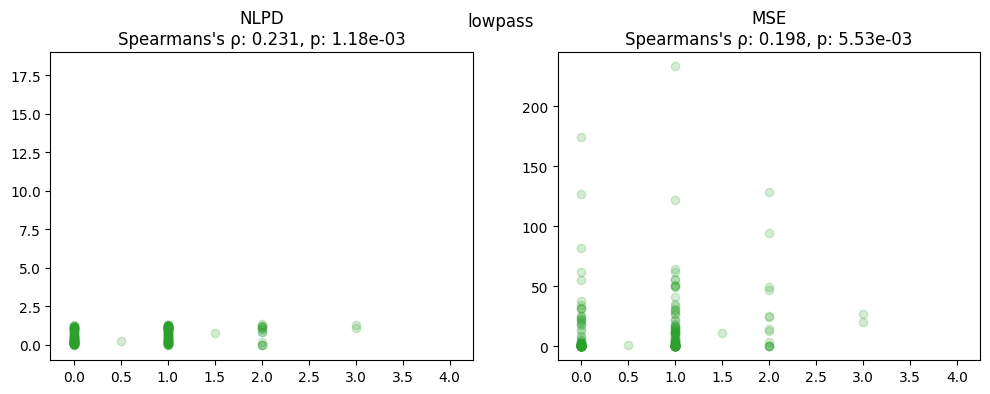

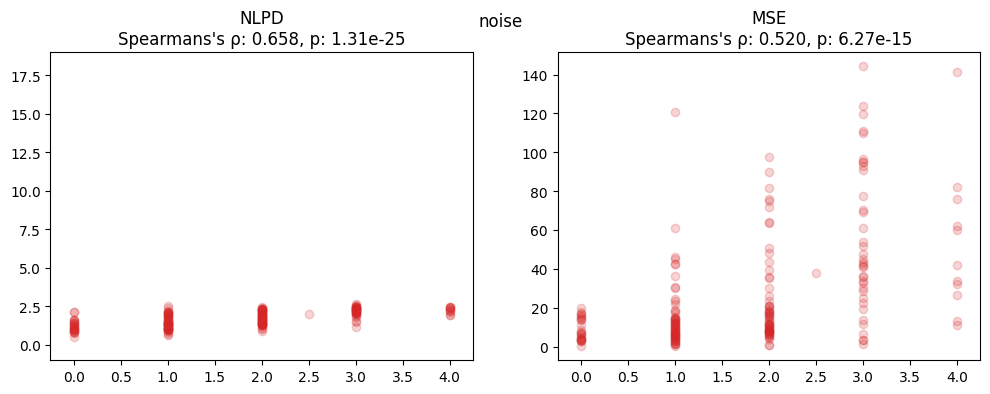

In [55]:
distortions = ['distortion','limiter','lowpass','noise']
for i1, i2 in combinations:
    pmdiff = []
    radiff = []
    mse = []
    for j in range(195):
        pmdiff.append(pmd.compare(omhn_norm[i1][j].unsqueeze(0).unsqueeze(0).float()*255, omhn_norm[i2][j].unsqueeze(0).unsqueeze(0).float()*255))
        mse.append(((omhn_norm[i1][j]*255-omhn_norm[i2][j]*255)**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

    sppm = spearmanr(radiff,pmdiff)
    spmse = spearmanr(radiff,mse)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 1

    ax[0].set_title(f"NLPD\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")

    ax[0].scatter(radiff,pmdiff, alpha=0.2, c=cycle[i2-1])
    ax[0].set_ylim(0-yoffset,18+yoffset)
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MSE\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,mse, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)

    plt.show()

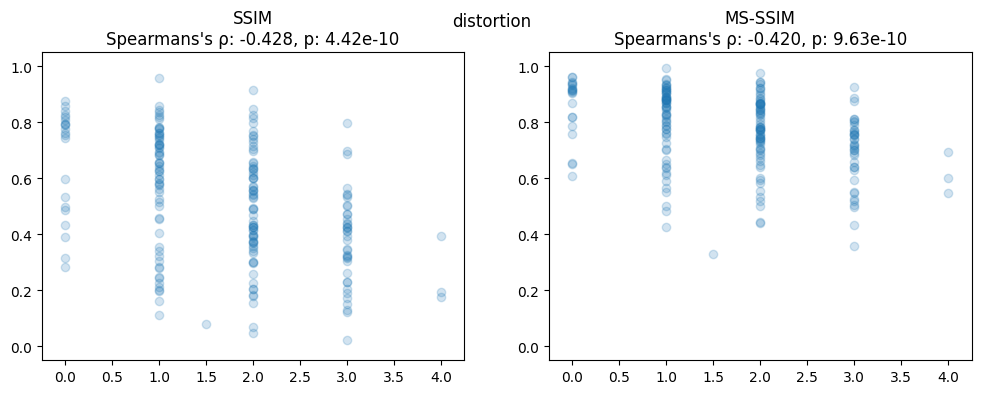

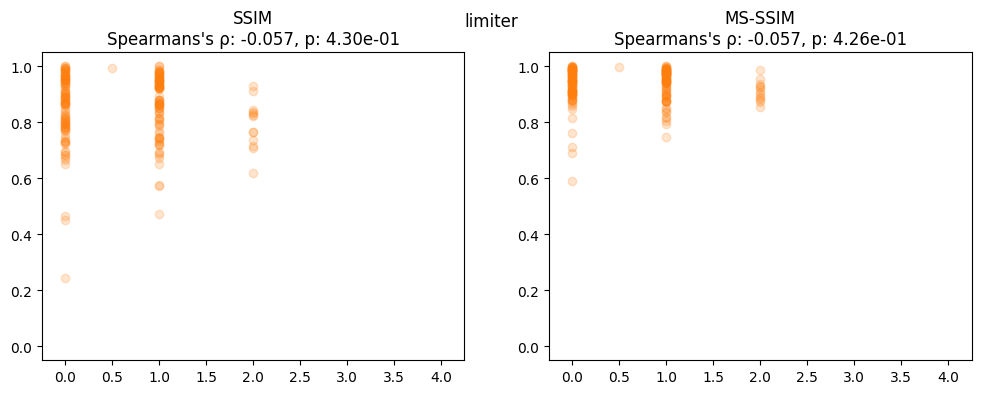

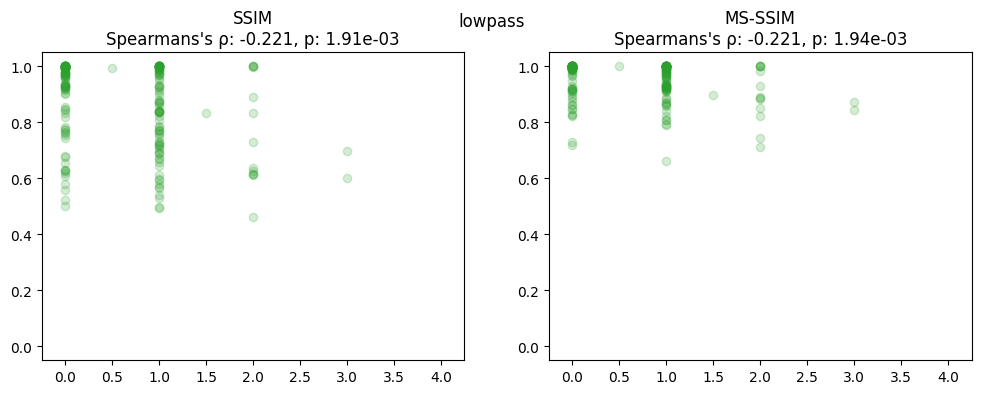

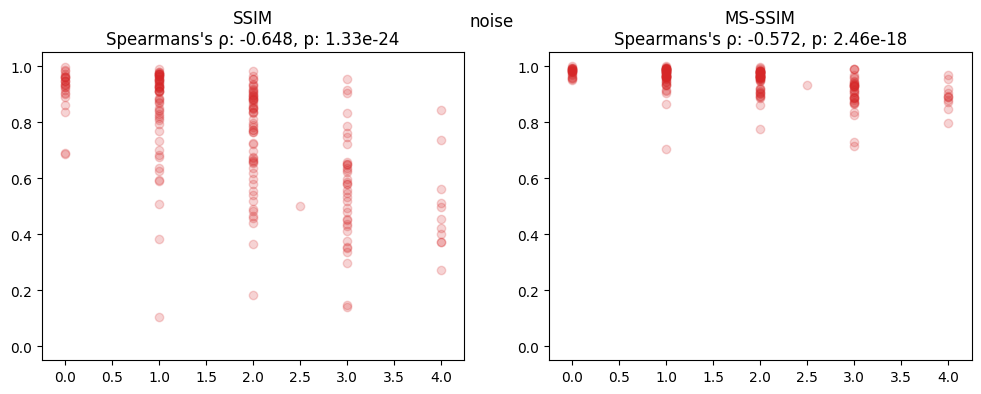

In [513]:
distortions = ['distortion','limiter','lowpass','noise']
from pytorch_msssim import ssim, ms_ssim

for i1, i2 in combinations:
    radiff= abs(rts[i1]-rts[i2])
    ssim_val = ssim(omhn_norm[i1].unsqueeze(1), omhn_norm[i2].unsqueeze(1), data_range=1,win_size = 7, size_average=False) # return (N,)
    ms_ssim_val = ms_ssim(omhn_norm[i1].unsqueeze(1), omhn_norm[i2].unsqueeze(1), data_range=1, win_size=7, size_average=False ) #(N,)

    """
    win size was 11 in original code, but changed here to 7 to accomodate smaller images for downscaling
    """

    spssim = spearmanr(radiff, ssim_val)
    spmsssim = spearmanr(radiff, ms_ssim_val)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 0.05

    ax[0].set_title(f"SSIM\nSpearmans's ρ: {spssim.statistic:.3f}, p: {spssim.pvalue:.2e}")

    ax[0].scatter(radiff,ssim_val, alpha=0.2, c=cycle[i2-1])
    ax[0].set_ylim(0-yoffset,1+yoffset)
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MS-SSIM\nSpearmans's ρ: {spmsssim.statistic:.3f}, p: {spmsssim.pvalue:.2e}")
    ax[1].scatter(radiff, ms_ssim_val, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)
    ax[1].set_ylim(0-yoffset,1+yoffset)

    plt.show()

In [31]:
df = pd.read_csv('/Users/up20938/Coding/datasets/pmqd/visqol_scores.csv')

In [39]:
visqol = []
for j in range(4):
    dis = []
    for i in range(195):
        dis.append(df.loc[i+(j*195)]['moslqo'])
    visqol.append(dis)

In [51]:
df2 = pd.read_csv('/Users/up20938/Coding/datasets/pmqd/fads.csv',header=None)

In [ ]:
fads = []
for j in range(4):
    dis = []
    for i in range(195):
        dis.append(df2.loc[i+(j*195)][0])
    fads.append(dis)

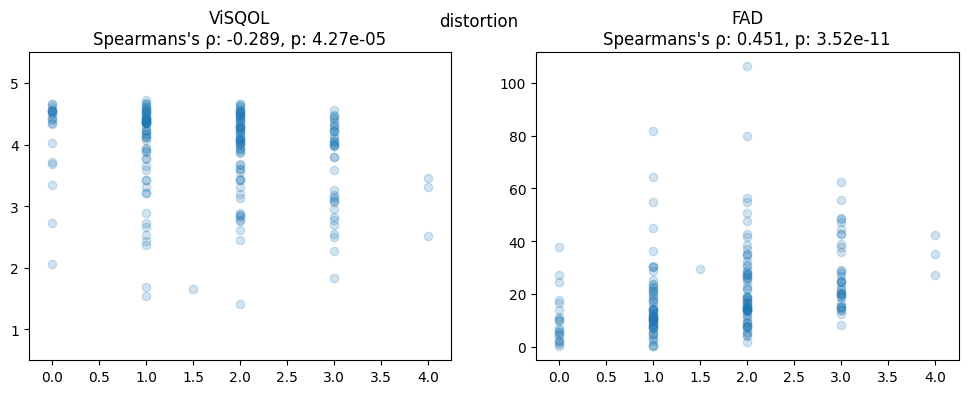

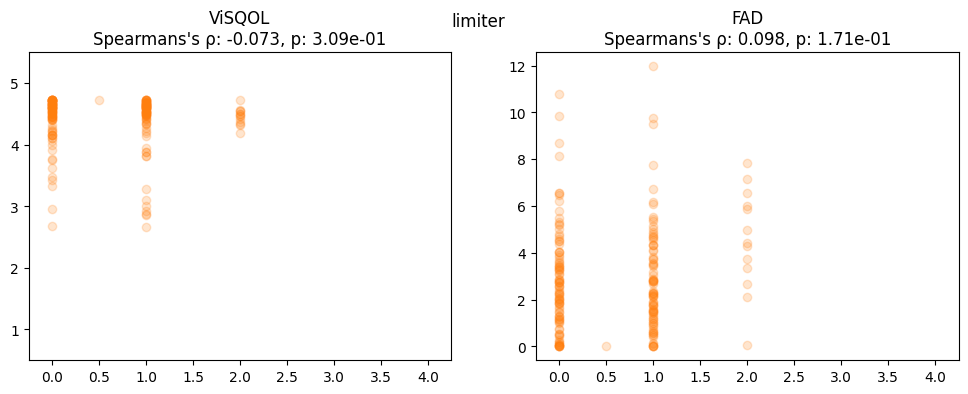

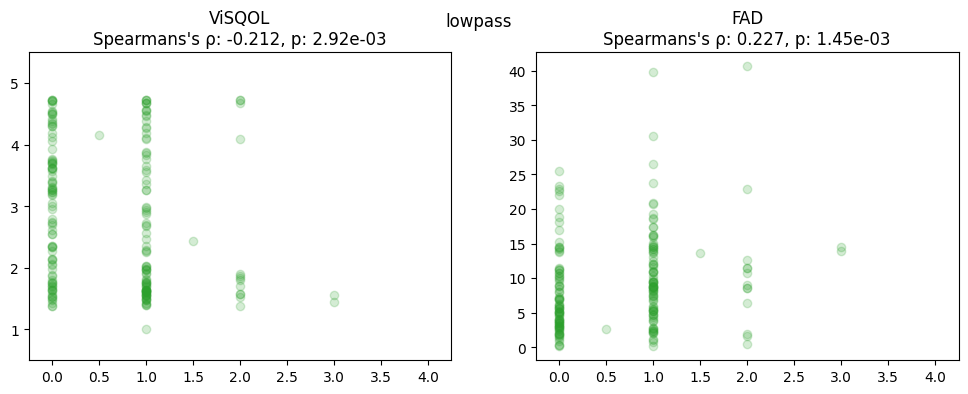

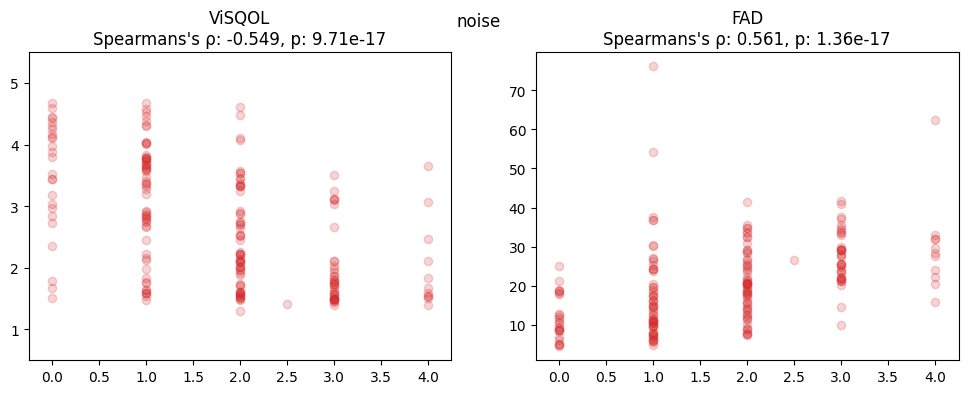

In [64]:
distortions = ['distortion','limiter','lowpass','noise']
for i1, i2 in combinations:
    pmdiff = []
    radiff = []
    mse = []
    for j in range(195):
        pmdiff.append(pmd.compare(omhn_norm[i1][j].unsqueeze(0).unsqueeze(0).float()*255, omhn_norm[i2][j].unsqueeze(0).unsqueeze(0).float()*255))
        mse.append(((omhn_norm[i1][j]*255-omhn_norm[i2][j]*255)**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))


    sppm = spearmanr(radiff,visqol[i2-1])
    spmse = spearmanr(radiff,fads[i2-1])


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 1

    ax[0].set_title(f"ViSQOL\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")
    ax[0].scatter(radiff,visqol[i2-1], alpha=0.2, c=cycle[i2-1])
    ax[0].set_xlim(0-xoffset,4+xoffset)
    ax[0].set_ylim(1-yoffset/2,5+yoffset/2)

    ax[1].set_title(f"FAD\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,fads[i2-1], alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)
    # ax[1].set_ylim(1-yoffset/2,5+yoffset/2)

    plt.show()

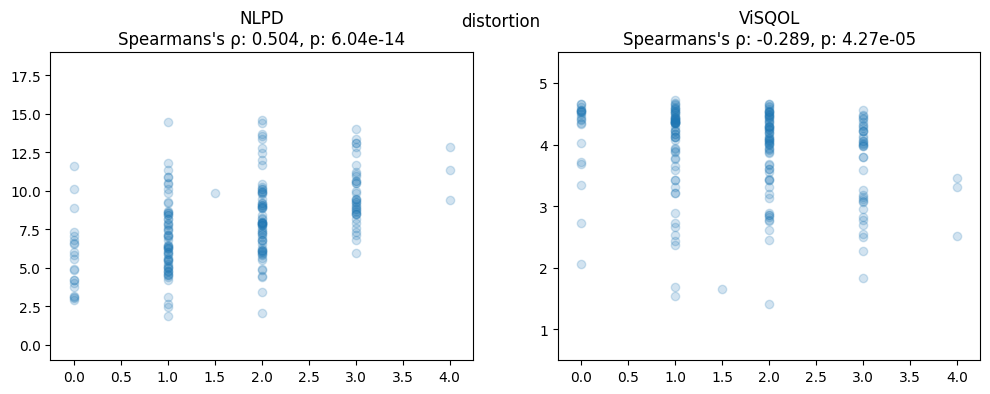

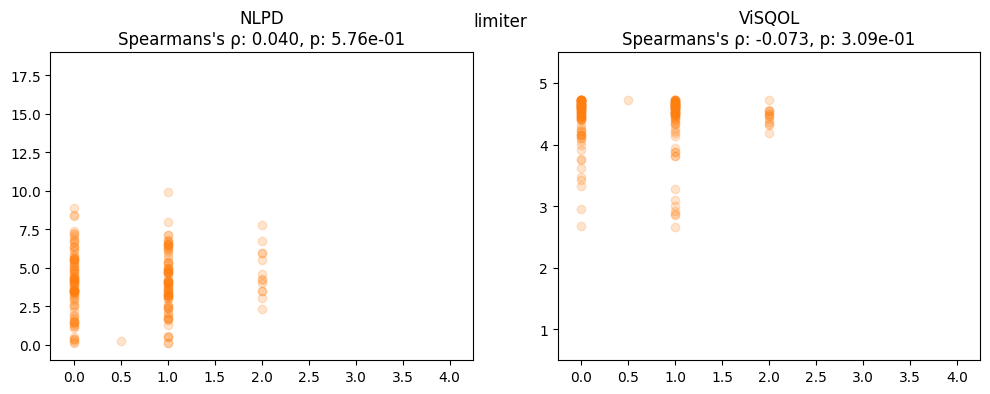

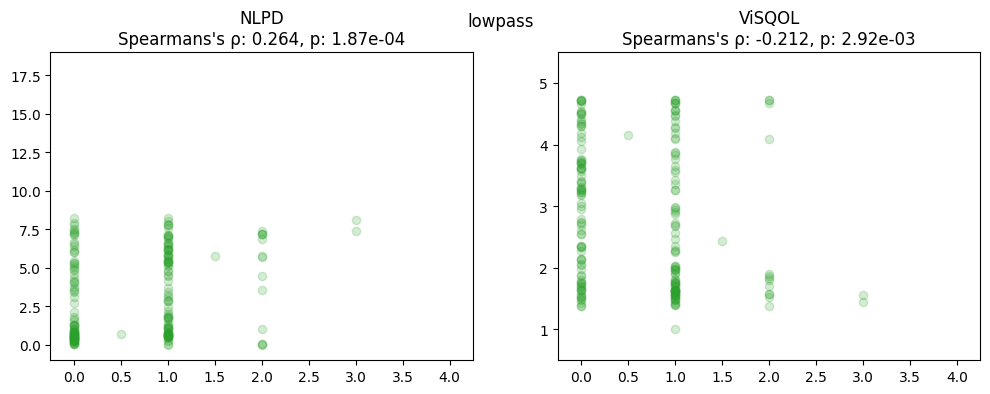

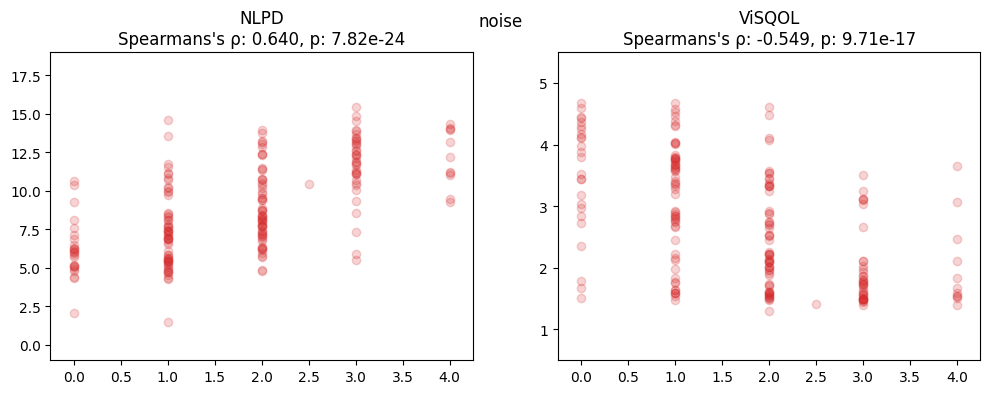

In [45]:
distortions = ['distortion','limiter','lowpass','noise']
for i1, i2 in combinations:
    pmdiff = []
    radiff = []
    mse = []
    for j in range(195):
        pmdiff.append(pmd.compare(omhn_norm[i1][j].unsqueeze(0).unsqueeze(0).float()*255, omhn_norm[i2][j].unsqueeze(0).unsqueeze(0).float()*255))
        mse.append(((omhn_norm[i1][j]*255-omhn_norm[i2][j]*255)**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))


    sppm = spearmanr(radiff,pmdiff)
    spmse = spearmanr(radiff,visqol[i2-1])


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 1

    ax[0].set_title(f"NLPD\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")

    ax[0].scatter(radiff,pmdiff, alpha=0.2, c=cycle[i2-1])
    ax[0].set_ylim(0-yoffset,18+yoffset)
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"ViSQOL\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,visqol[i2-1], alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)
    ax[1].set_ylim(1-yoffset/2,5+yoffset/2)

    plt.show()

/var/folders/mg/5nw9vnt14nb_0brnbqq48t0r0000gn/T/ipykernel_58008/3730570781.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.boxplot(np.array(list(bwp.values())).T, labels=np.arange(0,4.5,0.5))


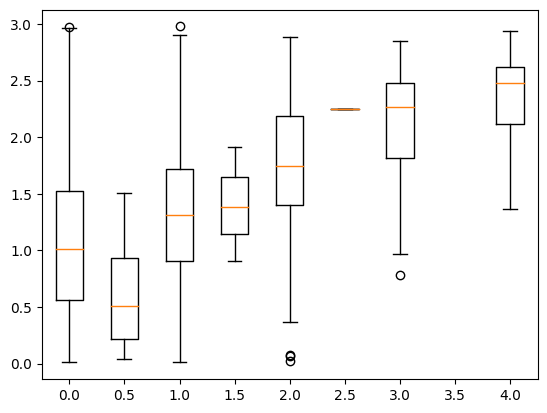

In [48]:
plt.boxplot(np.array(list(bwp.values())).T, labels=np.arange(0,4.5,0.5))
plt.show()

In [28]:
import numpy as np

In [47]:
bwp = dict(zip(np.arange(0,4.5,0.5),[[]]*len(radiff)))
for i in range(len(radiff)):
    bwp[float(radiff[i])]=bwp[float(radiff[i])]+[float(pmdiff[i])]

/var/folders/mg/5nw9vnt14nb_0brnbqq48t0r0000gn/T/ipykernel_58008/1497462131.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.boxplot(np.array(list(bwp.values())).T, labels=np.arange(0,4.5,0.5))


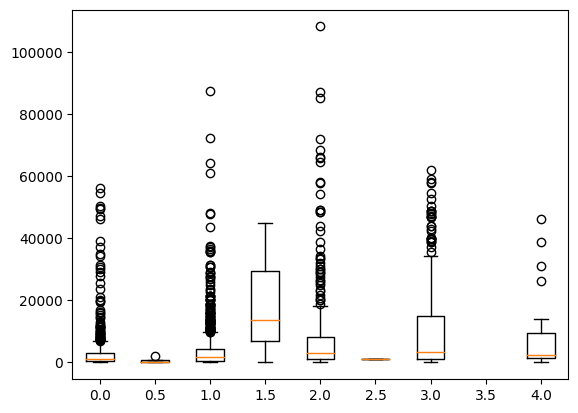

In [50]:
bwp = dict(zip(np.arange(0,4.5,0.5),[[]]*len(radiff)))
for i in range(len(radiff)):
    bwp[float(radiff[i])]=bwp[float(radiff[i])]+[float(mse[i])]
plt.boxplot(np.array(list(bwp.values())).T, labels=np.arange(0,4.5,0.5))
plt.show()

In [29]:
image = np.ones((128,256))*0.3

#It's a regression problem where you want to predict the absolute value of the central pixel given the neighbours.
# e.g pixel = 4,4
# then neighbourhood = [(3,3),(3,4),(3,5),(4,3),(4,5),(5,3),(5,4),(5,5)]

image_height = image.shape[0]
image_width = image.shape[1]

for i in range(1, image_height):
    if 0 < i < image_height-1: # don't choose pixels on border
        for j in range(image_width):
            if 0 < j < image_width-1: # don't choose pixels on border
                pixel = image[i,j]
                neighbourhood = np.array([[image[i-1, j-1], image[i-1, j], image[i-1, j+1],
                                           image[i, j-1],                  image[i, j+1],
                                           image[i+1, j-1], image[i+1, j], image[i+1, j+1]]])


# So for each pixel in some training set, you take the neighbourhood (and not the original pixel) and
# do a dot product with the filter.
# filter = torch.zeros((1,3,3))
filt = np.ones((8, 1))*0.5
print(neighbourhood.shape, filt.shape)
print(f'neighbourhood:\n{neighbourhood}')
print(f'filt:\n{filt}')
product = neighbourhood @ filt # 1x8 x 8x1 = 1x1
print(f'product:\n{product}')
# You then try to find the filter that minimises the difference between this dot product and the original pixel value (according to the squared difference).
print(f'pixel:\n{pixel}')
difference = (pixel - product) ** 2
print(f'difference:\n{difference}')
loss = -difference
print(f'loss:\n{loss}')
# The sigma is then just the mean of absolute value at each stage.
# MEAN ABSOLUTE VALUE OF PIXELS OR FILTER
sigma = filt.mean()
print(f'sigma:\n{sigma}')
# Valero thinks he restricted the filter values to be positive also. For the filters, it should just be a least squares solution.

(1, 8) (8, 1)
neighbourhood:
[[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]]
filt:
[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
product:
[[1.2]]
pixel:
0.3
difference:
[[0.81]]
loss:
[[-0.81]]
sigma:
0.5


tensor(0.9999) tensor(-0.9999)
tensor(580.7962) tensor(0.)


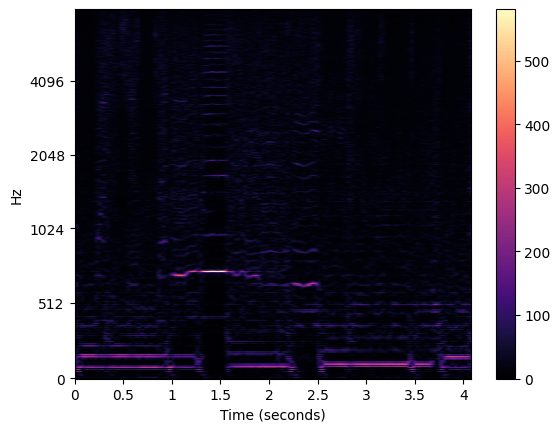

KeyError: 975

In [9]:
mins = []
maxs = []
for i,(d,e) in enumerate(TransformedPMQD(dataset,transforms=transforms)):
    if i == 195+123:
        print(e['audio'].max(), e['audio'].min())
        print(d.max(), d.min())
        specshow(
        d.numpy(),
        sr=reduced_sample_rate,
        hop_length=hop_size,
        x_axis="s",
        y_axis="mel"
    )
        plt.colorbar()
        plt.show()

    # i = torch.log(i + 1e-3).numpy()
    # # print(i.max(), i.min())
    # # S_dB = power_to_db(i, ref=np.max)
    # mins.append(i.min())
    # maxs.append(i.max())
print(np.min(mins), np.max(maxs))

In [30]:
np.array([[0, 0.0757, 0],
[0.1986, 0, 0.1846],
[0, 0.0837, 0]]).sum()/29

0.018710344827586205

In [36]:
print(df.loc[195])

reference        /Users/up20938/Coding/datasets/pmqd/16bit/ori0...
degraded         /Users/up20938/Coding/datasets/pmqd/16bit/lim0...
moslqo                                                    4.699158
fvnsim0                                                   0.988099
fvnsim1                                                   0.997691
                                       ...                        
fvdegenergy27                                            10.477547
fvdegenergy28                                             8.646268
fvdegenergy29                                             6.844611
fvdegenergy30                                             4.605247
fvdegenergy31                                             3.428484
Name: 195, Length: 131, dtype: object


In [ ]:
from librosa import power_to_db

for m in omhn:
    mins = []
    maxs = []
    for i in m:
        # i = torch.log(i + 1e-3).numpy()
        # print(i.max(), i.min())
        # S_dB = power_to_db(i, ref=np.max)
        mins.append(i.min())
        maxs.append(i.max(), )
    print(np.min(mins), np.max(maxs), np.argmax(maxs))

In [18]:
# for i in random.choices(range(len(dataset)), k=5):
for i in range(0,975,195):
    example = dataset[i]
    audio, rating = example["audio"], example["rating"]

    degradation_type = example["degradation_type"]
    degradation_intensity = example["degradation_intensity"]

    print(f"Degradation {degradation_type}({degradation_intensity:.2f}%) with rating {rating}: ")
    display(Audio(audio.numpy(), rate=sample_rate))

Degradation original(0.00%) with rating 4.0: 


Degradation distortion(44.74%) with rating 2.0: 


Degradation limiter(4.46%) with rating 4.0: 


Degradation lowpass(71.93%) with rating 3.0: 


Degradation noise(51.41%) with rating 2.0: 


tensor(1.) tensor(1.)
tensor(0.) tensor(270.1658)


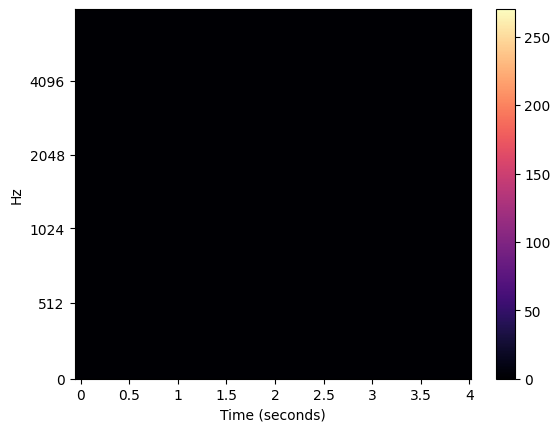

In [142]:
test_audio = (example['audio'][0])
for e, i in enumerate(test_audio):
   test_audio[e] = 1
print(test_audio.min(), test_audio.max())
test_spec = transforms(test_audio)
print(test_spec.min(),test_spec.max())
specshow(
    test_spec.numpy(),
    sr=reduced_sample_rate,
    hop_length=hop_size,
    x_axis="s",
    y_axis="mel"
)
plt.colorbar()
plt.show()